## Setup

In [1]:
!pip install Pillow livelossplot tf2onnx -U

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 435 kB 49.5 MB/s 
     |████████████████████████████████| 12.7 MB 17.1 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import os
import zipfile
from urllib import request
from typing import List

FONT_DIR = "fonts"
FONT_NAMES = ["roboto", "montserrat", "roboto-condensed", "roboto-mono", "raleway", "merriweather", "playfair-display", "roboto-slab"]

def download_fonts(fonts_dir: str, fonts: List[str]):
    os.makedirs("fonts")
    for font in fonts:
        request.urlretrieve(
            f"https://google-webfonts-helper.herokuapp.com/api/fonts/{font}?download=zip&subsets=latin",
            f"{fonts_dir}/{font}.zip"
        )
        os.makedirs(f"{fonts_dir}/{font}")
        with zipfile.ZipFile(f"{fonts_dir}/{font}.zip","r") as zip_file:
            zip_file.extractall(f"{fonts_dir}/{font}")

download_fonts(FONT_DIR, FONT_NAMES)

## Dataset

In [2]:
import glob

import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras import utils

LABELS_NUM = 10
IMAGE_WIDTH = 30
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_WIDTH)
TRAIN_LEN = 10000
VAL_LEN = 1000
BATCH_SIZE = 20
FONTS = [ImageFont.truetype(font_file, IMAGE_WIDTH) for font_name in FONT_NAMES for font_file in glob.glob(f"{FONT_DIR}/{font_name}/*.ttf")]

def draw_image(list_len: int, augment: bool):
    i = 0
    while i < list_len:
        image = Image.new("RGB", IMAGE_SIZE, color=(
            tf.random.uniform([], minval=240, maxval=256, dtype=tf.int32),
            tf.random.uniform([], minval=240, maxval=256, dtype=tf.int32),
            tf.random.uniform([], minval=240, maxval=256, dtype=tf.int32),
        ) if augment else (255, 255, 255))
        width, height = IMAGE_SIZE
        digit = int(tf.random.uniform([], minval=0, maxval=LABELS_NUM, dtype=tf.int32)) if augment else i % LABELS_NUM
        ImageDraw.Draw(image).text(
            (width / 2, height / 2),
            "" if digit == 0 else str(digit),
            fill=(
                tf.random.uniform([], minval=0, maxval=8, dtype=tf.int32),
                tf.random.uniform([], minval=0, maxval=8, dtype=tf.int32),
                tf.random.uniform([], minval=0, maxval=8, dtype=tf.int32),
            ) if augment else (0, 0, 0),
            font=FONTS[tf.random.uniform([], minval=0, maxval=len(FONTS), dtype=tf.int32) if augment else i % len(FONTS)],
            anchor="mm"
        )
        if augment:
            image = image.transform(IMAGE_SIZE, Image.AFFINE, data=(
                tf.random.uniform([], minval=0.9, maxval=1.1),
                tf.random.uniform([], minval=-0.1, maxval=0.1),
                tf.random.uniform([], minval=-width * 0.1, maxval=width * 0.1),
                tf.random.uniform([], minval=-0.1, maxval=0.1),
                tf.random.uniform([], minval=0.9, maxval=1.1),
                tf.random.uniform([], minval=-height * 0.1, maxval=height * 0.1),
            ))
            image = image.rotate(tf.random.uniform([], minval=-15, maxval=15))
        yield np.array(image.convert("L"))[..., np.newaxis] / 255, utils.to_categorical(digit, num_classes=LABELS_NUM)
        i += 1

def generate_dataset(list_len: int, augment: bool):
    return tf.data.Dataset.from_generator(draw_image, output_signature=(
        tf.TensorSpec(shape=IMAGE_SIZE + (1,), dtype=tf.float32),
        tf.TensorSpec(shape=LABELS_NUM, dtype=tf.int32),
    ), args=[list_len, augment]).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

train_dataset = generate_dataset(TRAIN_LEN, True)
val_dataset = generate_dataset(VAL_LEN, False)

## Model

In [3]:
from tensorflow.keras import Input, Sequential, layers

model = Sequential(layers=[
    Input(shape=IMAGE_SIZE + (1,)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(LABELS_NUM, activation="softmax"),
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## Training

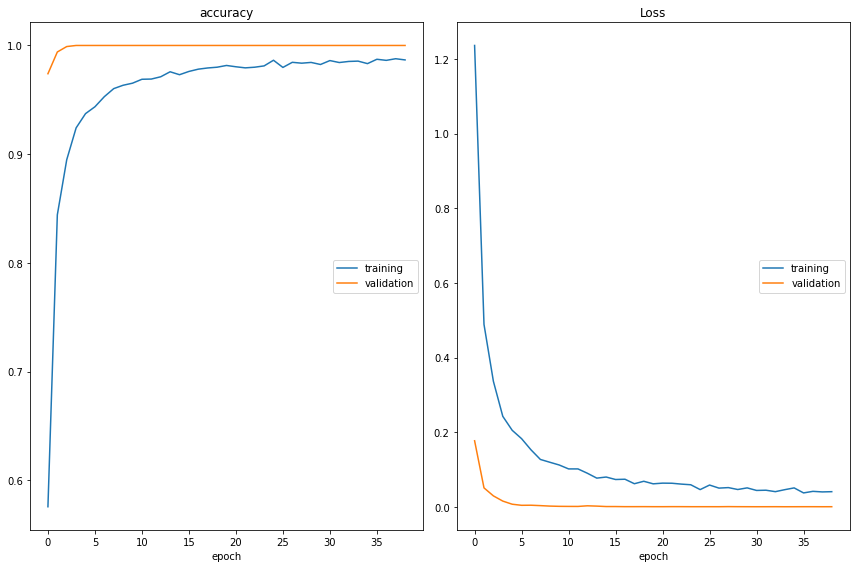

accuracy
	training         	 (min:    0.576, max:    0.988, cur:    0.987)
	validation       	 (min:    0.974, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.037, max:    1.236, cur:    0.040)
	validation       	 (min:    0.000, max:    0.177, cur:    0.000)
500/500 [==============================] - 96s 191ms/step - loss: 0.0404 - accuracy: 0.9867 - val_loss: 9.6029e-05 - val_accuracy: 1.0000


In [4]:
from livelossplot import PlotLossesKerasTF
from tensorflow.keras import callbacks

EPOCHS_NUM = 10000
CHECKPOINT_PATH = "saved"

model.fit(
    train_dataset,
    epochs=EPOCHS_NUM,
    callbacks=[
        callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True),
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        PlotLossesKerasTF(),
    ],
    validation_data=val_dataset,
)

In [5]:
from google import colab

MODEL_FILE = "model.onnx"

!python -m tf2onnx.convert --saved-model {CHECKPOINT_PATH} --output {MODEL_FILE}
colab.files.download(MODEL_FILE)

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-12-04 02:52:24,378 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2021-12-04 02:52:24,714 - INFO - Signatures found in model: [serving_default].
2021-12-04 02:52:24,714 - WARNING - '--signature_def' not specified, using first signature: serving_default
2021-12-04 02:52:24,714 - INFO - Output names: ['dense']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-12-04 02:52:24,784 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-12-04 02:52:24,808 - INFO - Using tenso

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>